## Predict story topics using  word vectors

In [2]:
# import relevant libraries
import pandas as pd
import numpy as np
import re
import functools
from operator import add
import seaborn as sns
import matplotlib.pyplot as plt

# import libraries for NLP
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn import metrics


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes


# Import Reuters data
from nltk.corpus import reuters

The aim of this project is to predict the topic a news article deals with, given a set of five different topics. I will use the Reuters corpus which comprises news stories that are labelled to topics. I will use a Naive Bayes model to predict the new labels based on the known stories. Unkonwn stories should then be classified if related to one of the topics.

I will pick topics for prediction that are distinct with regards to the vocabulary they are using to be able to make better predictions. Distinct vocabulary will ensure that the model works better on incoming stories, since ther will be little overlap in the features.

## Get data from Reuters corpus

The Reuters Corpus contains 10,788 news documents totaling 1.3 million words. The documents have been classified into 90 topics, and grouped into two sets, called "training" and "test". The text with fileid 'test/14826' is a document drawn from the test set.

In [3]:
# get all labels that are available
labels = reuters.categories()

print("Corpus has " + str(len(labels)) + " labels:")
print("\n")
print(labels)

Corpus has 90 labels:


['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


We can ask for the topics covered by one or more documents, or for the documents included in one or more categories. The corpus methods accept a single fileid or a list of fileids.

In [4]:
# get document IDs
documents = reuters.fileids()

In [5]:
# get labells from story number 9865
reuters.categories('training/9865')

['barley', 'corn', 'grain', 'wheat']

In [6]:
# get field IDs for stories that are tagged to "Barley"
reuters.fileids('rye')

['test/19668', 'training/97']

The split used is named Mod-Apte which only considers categories that have at least one document in the training set and the test set. The Mod-Apte split has 90 categories with a training set of 7769 documents and a test set of 3019 documents.

In [7]:
# get document IDs for train and test data
# to split in train and test data
test = [d for d in documents if d.startswith('test/')]
train = [d for d in documents if d.startswith('training/')]

In [8]:
# Len of test and training data 
print("Length of test data: " + str(len(test)))
print("Length of training data: " + str(len(train)))

print("Length of whole corpus: " + str(len(test)+len(train)))

Length of test data: 3019
Length of training data: 7769
Length of whole corpus: 10788


In [9]:
# it is possible to get the words of each article by calling the .word() function.
# Headlines are capitalized and list also comprises punctuation
reuters.words('test/19668')

['DANISH', 'CROPS', 'TWO', 'WEEKS', 'BEHIND', ',', ...]

# Decide which labels to pick

To predict topics based on language, a sufficiently large training data is needed. Thus, it will only be possible to use labels that have more than 25 stories assigned to them.

In [10]:
# Are enough stories tagged to each label in the training data to create vectors?
# Assumption: more than 25 stories are need to have relevant vocabulary

import operator

numberStories = {}

for label in labels:
    story_list = reuters.fileids(label)
    training_stories = []
    for item in story_list:
        if item.startswith("training"):
            training_stories.append(item)
    numberStories[label] = len(training_stories)

# get frequency of tag on the whole corpus
sorted_dict = sorted(numberStories.items(), key=operator.itemgetter(1))
print(sorted_dict)


[('castor-oil', 1), ('cotton-oil', 1), ('groundnut-oil', 1), ('lin-oil', 1), ('nkr', 1), ('rye', 1), ('sun-meal', 1), ('copra-cake', 2), ('dfl', 2), ('naphtha', 2), ('nzdlr', 2), ('palladium', 2), ('palmkernel', 2), ('rand', 2), ('cpu', 3), ('potato', 3), ('propane', 3), ('coconut', 4), ('coconut-oil', 4), ('jet', 4), ('groundnut', 5), ('instal-debt', 5), ('platinum', 5), ('rape-oil', 5), ('sun-oil', 5), ('l-cattle', 6), ('nickel', 8), ('oat', 8), ('income', 9), ('tea', 9), ('dmk', 10), ('lumber', 10), ('sunseed', 11), ('lei', 12), ('fuel', 13), ('soy-meal', 13), ('heat', 14), ('soy-oil', 14), ('lead', 15), ('hog', 16), ('housing', 16), ('orange', 16), ('strategic-metal', 16), ('rapeseed', 18), ('tin', 18), ('wpi', 19), ('pet-chem', 20), ('silver', 21), ('zinc', 21), ('retail', 23), ('sorghum', 24), ('meal-feed', 30), ('palm-oil', 30), ('alum', 35), ('rice', 35), ('barley', 37), ('gas', 37), ('rubber', 37), ('cotton', 39), ('iron-steel', 40), ('ipi', 41), ('yen', 45), ('jobs', 46), ('c

In [11]:
print(numberStories)

{'acq': 1650, 'alum': 35, 'barley': 37, 'bop': 75, 'carcass': 50, 'castor-oil': 1, 'cocoa': 55, 'coconut': 4, 'coconut-oil': 4, 'coffee': 111, 'copper': 47, 'copra-cake': 2, 'corn': 181, 'cotton': 39, 'cotton-oil': 1, 'cpi': 69, 'cpu': 3, 'crude': 389, 'dfl': 2, 'dlr': 131, 'dmk': 10, 'earn': 2877, 'fuel': 13, 'gas': 37, 'gnp': 101, 'gold': 94, 'grain': 433, 'groundnut': 5, 'groundnut-oil': 1, 'heat': 14, 'hog': 16, 'housing': 16, 'income': 9, 'instal-debt': 5, 'interest': 347, 'ipi': 41, 'iron-steel': 40, 'jet': 4, 'jobs': 46, 'l-cattle': 6, 'lead': 15, 'lei': 12, 'lin-oil': 1, 'livestock': 75, 'lumber': 10, 'meal-feed': 30, 'money-fx': 538, 'money-supply': 140, 'naphtha': 2, 'nat-gas': 75, 'nickel': 8, 'nkr': 1, 'nzdlr': 2, 'oat': 8, 'oilseed': 124, 'orange': 16, 'palladium': 2, 'palm-oil': 30, 'palmkernel': 2, 'pet-chem': 20, 'platinum': 5, 'potato': 3, 'propane': 3, 'rand': 2, 'rape-oil': 5, 'rapeseed': 18, 'reserves': 55, 'retail': 23, 'rice': 35, 'rubber': 37, 'rye': 1, 'ship': 1

## Most labels occure not very often

In [12]:
# Create dataframe with labels and number how often they occur in the corpus
df_labels = pd.DataFrame.from_dict(numberStories, orient = 'index')
df_labels.sort_values(by=0, ascending=False, inplace=True)

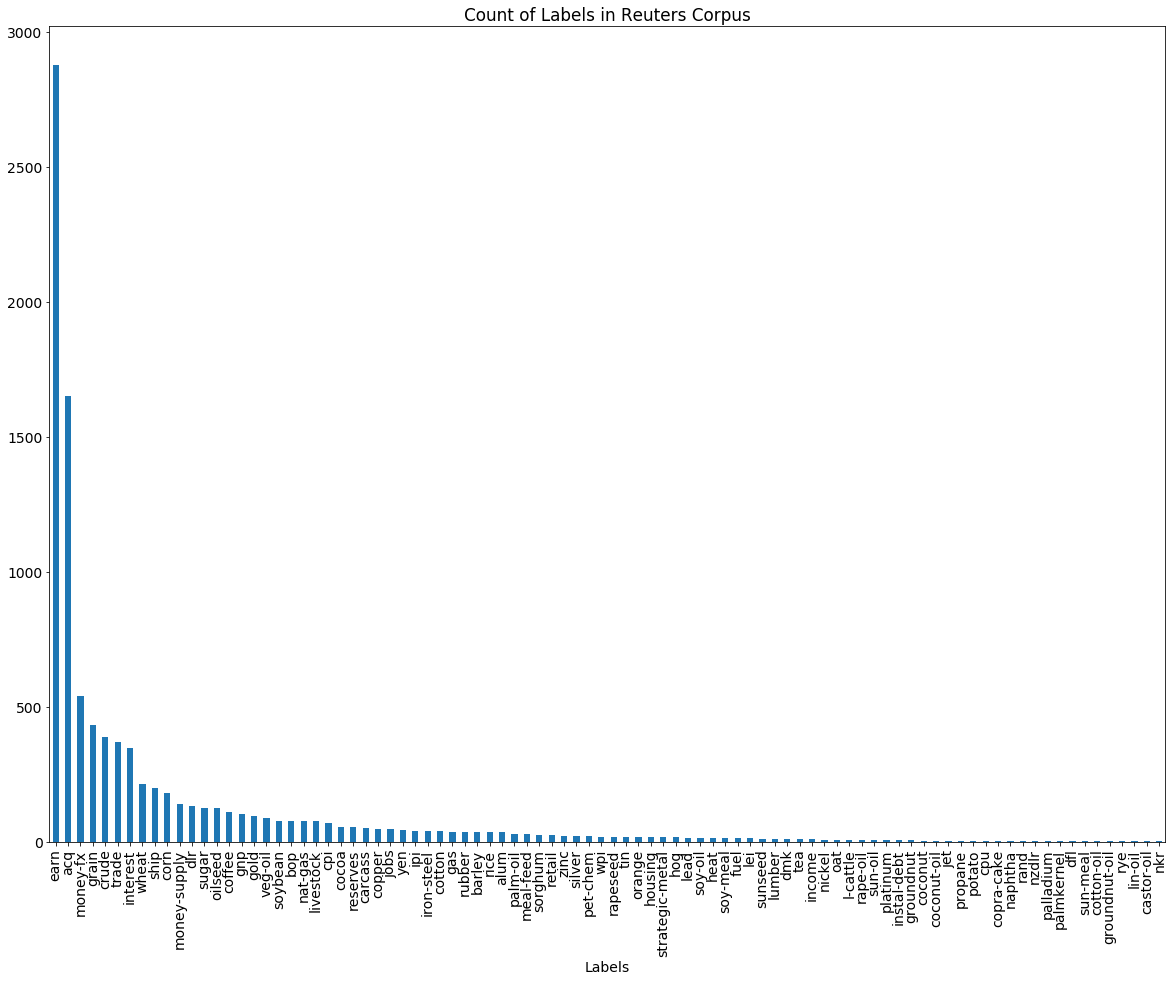

In [81]:
# Create a visualisation of the label count

df_labels[0].plot(kind='bar')

plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['font.size'] = 14
plt.xlabel("Labels")    
plt.title("Count of Labels in Reuters Corpus")

plt.show()

I will get rid of all labels that have less than 25 stories assigned.

In [14]:
# Keep only taggs that have more than 25 stories assigned
# 39 labels remain from which I can pick
label_list = []

for key, value in numberStories.items():
    if value > 25:
        label_list.append(key)
           
print("Number of labels with more than 25 stories assigned is " + str(len(label_list)))
print("\n")
print(label_list)

Number of labels with more than 25 stories assigned is 39


['acq', 'alum', 'barley', 'bop', 'carcass', 'cocoa', 'coffee', 'copper', 'corn', 'cotton', 'cpi', 'crude', 'dlr', 'earn', 'gas', 'gnp', 'gold', 'grain', 'interest', 'ipi', 'iron-steel', 'jobs', 'livestock', 'meal-feed', 'money-fx', 'money-supply', 'nat-gas', 'oilseed', 'palm-oil', 'reserves', 'rice', 'rubber', 'ship', 'soybean', 'sugar', 'trade', 'veg-oil', 'wheat', 'yen']


# Are all these labels present in the test and training data?

I need labels that are present in the test as well as the training data to train the model as well as to make predictions. 

In [15]:
# Are these labels present in the test data?
test_label_list = []

# get all labels present in test data
for story in test:
    labels = reuters.categories(story)
    test_label_list.append(labels) 

In [16]:
# Flatten the list
test_label_list = functools.reduce(add, test_label_list)

In [17]:
# get rid of duplicates
set_label = list(set(test_label_list))

# print the label if it is not present in the test set
flag = False
for label in label_list:
    if label not in set_label:
        flag = True
        print(label)
if flag == True:
    print("These labels are not in the test data")
else:
    print("All labels are present in test data")
    

All labels are present in test data


In [18]:
# Are these labels present in the training data?
train_label_list = []

# get all labels present in training data
for story in train:
    labels = reuters.categories(story)
    train_label_list.append(labels) 

In [19]:
# Flatten the list
train_label_list = functools.reduce(add, train_label_list)

In [20]:
# get rid of duplicates
set_label = list(set(train_label_list))

# print the label if it is not present in the test set
flag = False
for label in label_list:
    if label not in set_label:
        flag = True
        print(label)

if flag == True:
    print("These labels are not in the training data")
else:
    print("All labels are present in training data")

All labels are present in training data


# Handpick labels that supposedly have distinct vocabulary

I will pick 5 labels of topics that use vocabulary that is easy to distinguish. The more distinct the vocabulary that is used to describe the topics, the more precise the model will work on new stories. If the vocabulary is very similar, it will be difficult to predict the topic based on the vocabulary and it is likely that more false positives will occure. It should be unlikely that the same words are used for two topics.

In [21]:
# hand-picking five unrelated topics
labels = ['trade', 'ship', 'sugar', 'money-fx', 'jobs']

In [22]:
### Look at some word lists for the label trade

trade_fID = reuters.fileids('trade')[0:3]

for label in trade_fID:
    story = reuters.words(label)
    print(story[0:150])

['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.', 'They', 'told', 'Reuter', 'correspondents', 'in', 'Asian', 'capitals', 'a', 'U', '.', 'S', '.', 'Move', 'against', 'Japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'U', '.', 'S', '.', 'And', 'lead', 'to', 'curbs', 'on', 'American', 'imports', 'of', 'their', 'products', '.', 'But', 'some', 'exporters', 'said', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', '-', 'run', ',', 'in', 'the', 'short', '-', 'term', 'Tokyo', "'", 's', 'loss', 'might', 'be', 'their', 'gain', '.', 'The', 'U', '.', 'S', '.', 'Has', 'said', 'it', 'will', 'impose'

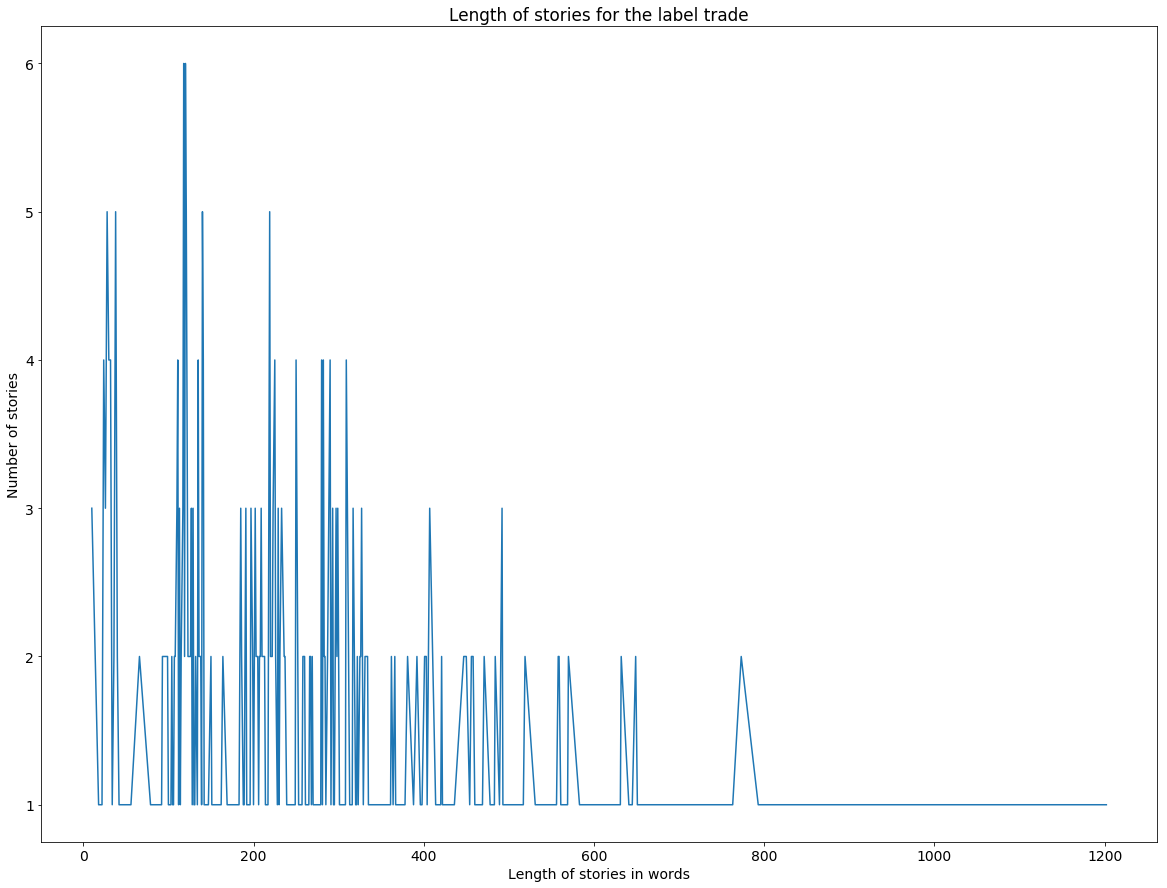

In [23]:
# plott the length of the news articles
trade_fID = reuters.fileids('trade')
story_len={}

for label in trade_fID:
    story = len(reuters.words(label))
    if story in story_len:
        story_len[story] += 1
    else:
        story_len[story] = 1


lists = sorted(story_len.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.xlabel("Length of stories in words")  
plt.ylabel("Number of stories")    

plt.title("Length of stories for the label trade")

plt.show()

In [24]:
# looking at some word lists for the label 'sugar'
sugar_fID = reuters.fileids('sugar')[0:3]

for label in sugar_fID:
    story = reuters.words(label)
    print(story[0:150])

['THAI', 'TRADE', 'DEFICIT', 'WIDENS', 'IN', 'FIRST', 'QUARTER', 'Thailand', "'", 's', 'trade', 'deficit', 'widened', 'to', '4', '.', '5', 'billion', 'baht', 'in', 'the', 'first', 'quarter', 'of', '1987', 'from', '2', '.', '1', 'billion', 'a', 'year', 'ago', ',', 'the', 'Business', 'Economics', 'Department', 'said', '.', 'It', 'said', 'Janunary', '/', 'March', 'imports', 'rose', 'to', '65', '.', '1', 'billion', 'baht', 'from', '58', '.', '7', 'billion', '.', 'Thailand', "'", 's', 'improved', 'business', 'climate', 'this', 'year', 'resulted', 'in', 'a', '27', 'pct', 'increase', 'in', 'imports', 'of', 'raw', 'materials', 'and', 'semi', '-', 'finished', 'products', '.', 'The', 'country', "'", 's', 'oil', 'import', 'bill', ',', 'however', ',', 'fell', '23', 'pct', 'in', 'the', 'first', 'quarter', 'due', 'to', 'lower', 'oil', 'prices', '.', 'The', 'department', 'said', 'first', 'quarter', 'exports', 'expanded', 'to', '60', '.', '6', 'billion', 'baht', 'from', '56', '.', '6', 'billion', '.',

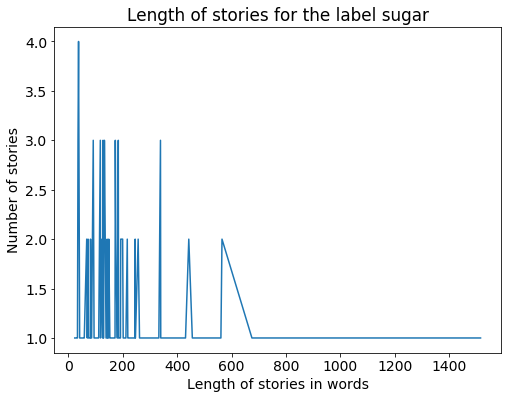

In [25]:
# plott the length of the news articles
trade_fID = reuters.fileids('sugar')
story_len={}

for label in trade_fID:
    story = len(reuters.words(label))
    if story in story_len:
        story_len[story] += 1
    else:
        story_len[story] = 1


lists = sorted(story_len.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.xlabel("Length of stories in words")  
plt.ylabel("Number of stories")    

plt.title("Length of stories for the label sugar")

plt.show()

Headlines in the Reuters Corpus are capitalized. Thus, I will have to lowercase all words to make them comparable. Otherwise the computer will categorise them as different words.

Many words seem to appear in stories for both topics. Also, punctuation is included in the word list. Will need further processing to destille vocabulary.

Most stories are longer than 500 words so that most of the vocabulary for the stories will be used for the analysis.

## Further Pre-Processing on Words Lists

In [26]:
# create dataframe with text and labels in columns
# remove punctuation from text
import string
import re

columns = ['story_ID', 'story_text', 'label']
data_set = pd.DataFrame(index= [], columns=columns)

for label in labels:
    # retrieve all storyIDs related to trade
    storyIDs = reuters.fileids(label)
    # filter for training data
    IDs_training = [Id for Id in storyIDs if Id.startswith('training')]
    # get nested list of words of story IDs
    word_list = []
    for storyID in IDs_training:
        label_words = list(reuters.words(storyID))
        # remove punctuation from the list
        label_words_pct = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in label_words]
        label_words_clean = [x for x in label_words_pct if x]
        # remove numbers
        only_words = [word for word in label_words_clean if not word.isdigit()]
        word_list.append(only_words)
    # Create pandas dataframe with all train IDs and the story text
    d = {'story_ID': IDs_training, 'story_text': word_list, 'label': label}
    df = pd.DataFrame(data=d)
    data_set = pd.concat([data_set, df], ignore_index=True)
    

In [27]:
# data set to predict a label based on the vocabulary of the present labels
data_set.shape

(1275, 3)

In [28]:
data_set.head()

,label,story_ID,story_text
0,trade,training/10005,"[U, K, GROWING, IMPATIENT, WITH, JAPAN, THATCH..."
1,trade,training/10209,"[WHITE, HOUSE, UNIT, DECIDES, ON, SEMICONDUCTO..."
2,trade,training/1022,"[CHINA, CALLS, FOR, BETTER, TRADE, DEAL, WITH,..."
3,trade,training/10255,"[GATT, WARNS, U, S, ON, FEDERAL, BUDGET, PROTE..."
4,trade,training/10264,"[WHITE, HOUSE, PANEL, SAID, URGING, JAPAN, RET..."


## What percentage of stories is labelled to each topic in training set?

In [29]:
# What percentage of stories belongs to each label
percentage_label = data_set.groupby('label')['story_ID'].count()
percentage_label

label
jobs         46
money-fx    538
ship        197
sugar       126
trade       368
Name: story_ID, dtype: int64

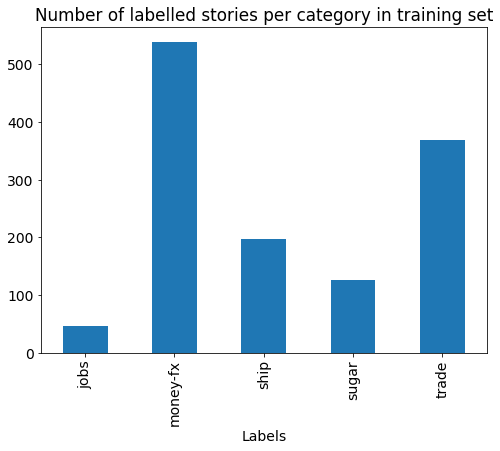

In [30]:
percentage_label.plot(kind='bar')

plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['font.size'] = 14
plt.xlabel("Labels")    
plt.title("Number of labelled stories per category in training set")

plt.show()

In [31]:
# get the percentage of labels in each category

import math
percentage = []

labels = percentage_label.keys().tolist()

for i,label in enumerate(percentage_label):
    print(str(labels[i]) + ' '+ str(math.floor(label/1467*100)) + " percent")
    
    percentage.append((labels[i], math.floor(label/1467*100)))

jobs 3 percent
money-fx 36 percent
ship 13 percent
sugar 8 percent
trade 25 percent


In [32]:
percentage

[('jobs', 3), ('money-fx', 36), ('ship', 13), ('sugar', 8), ('trade', 25)]

## Get vocabulary to train model

I assume that the most important vocabulary will be in the headline and the first 500 words of a story. Journalists usually refer in the headline and the first paragraph to the topic they are covering. Thus, I will only use that vocabulary for predictions.

Also, as we have seen from looking at sugar and trade labels, most stories are shorter than 500 words.

In [33]:
# assumption is that most important content will be present in first 500 words of the story and the headline
# only take the first 500 words from each story

data_set['first_500'] = data_set[['story_text'][0:500]]

In [34]:
# create new column that has text data as string
# combining words to string to be able to apply to countvectorizer
data_set['text_string']=data_set['first_500'].transform(lambda x: ' '.join(x))

In [35]:
data_set.tail()

,label,story_ID,story_text,first_500,text_string
1270,jobs,training/9751,"[KEATING, REVISES, DOWN, AUSTRALIAN, GROWTH, F...","[KEATING, REVISES, DOWN, AUSTRALIAN, GROWTH, F...",KEATING REVISES DOWN AUSTRALIAN GROWTH FORECAS...
1271,jobs,training/9805,"[FRENCH, UNEMPLOYMENT, RISES, TO, SEASONALLY, ...","[FRENCH, UNEMPLOYMENT, RISES, TO, SEASONALLY, ...",FRENCH UNEMPLOYMENT RISES TO SEASONALLY ADJUST...
1272,jobs,training/9812,"[FRENCH, FEBRUARY, UNEMPLOYMENT, HITS, RECORD,...","[FRENCH, FEBRUARY, UNEMPLOYMENT, HITS, RECORD,...",FRENCH FEBRUARY UNEMPLOYMENT HITS RECORD MLN F...
1273,jobs,training/9834,"[U, S, FIRST, TIME, JOBLESS, CLAIMS, ROSE, IN,...","[U, S, FIRST, TIME, JOBLESS, CLAIMS, ROSE, IN,...",U S FIRST TIME JOBLESS CLAIMS ROSE IN WEEK New...
1274,jobs,training/9897,"[KEATING, REVISES, DOWN, AUSTRALIAN, GROWTH, F...","[KEATING, REVISES, DOWN, AUSTRALIAN, GROWTH, F...",KEATING REVISES DOWN AUSTRALIAN GROWTH FORECAS...


## Look at Word Frequency for the Labels

To get a better idea of the vocabulary used for different topics, I will look at the most frequently used words in the articles.

I will take the label 'sugar' and 'jobs' as examples.

In [36]:
# filtering for series containing the words related to 'jobs'
jobs = data_set[(data_set['label']=='jobs')]['first_500']

In [37]:
jobs.tolist()

job_words = []
for item in jobs:
    job_words += item

# Counting the frequency of words
from collections import Counter
c = Counter(job_words)
c.most_common(30)

[('the', 499),
 ('in', 328),
 ('to', 216),
 ('of', 213),
 ('pct', 193),
 ('and', 161),
 ('a', 157),
 ('said', 142),
 ('The', 102),
 ('year', 95),
 ('from', 93),
 ('unemployment', 79),
 ('February', 75),
 ('s', 74),
 ('January', 67),
 ('was', 60),
 ('by', 54),
 ('is', 53),
 ('for', 52),
 ('at', 51),
 ('last', 50),
 ('with', 49),
 ('that', 49),
 ('rate', 48),
 ('mln', 45),
 ('government', 39),
 ('S', 39),
 ('growth', 37),
 ('U', 37),
 ('this', 35)]

In [38]:
# filtering for series containing the words related to 'sugar'
sugar = data_set[(data_set['label']=='sugar')]['first_500']

In [39]:
sugar.tolist()

sugar_words = []
for item in sugar:
    sugar_words += item

# Counting the frequency of words    
from collections import Counter
c = Counter(sugar_words)
c.most_common(30)

[('the', 1268),
 ('to', 785),
 ('of', 668),
 ('and', 532),
 ('in', 527),
 ('said', 481),
 ('sugar', 418),
 ('a', 416),
 ('tonnes', 309),
 ('for', 293),
 ('The', 241),
 ('is', 211),
 ('mln', 203),
 ('from', 187),
 ('at', 183),
 ('year', 163),
 ('s', 162),
 ('be', 151),
 ('by', 141),
 ('was', 135),
 ('it', 132),
 ('with', 125),
 ('EC', 123),
 ('on', 122),
 ('that', 122),
 ('are', 121),
 ('have', 116),
 ('this', 115),
 ('U', 115),
 ('will', 114)]

Most of the words used most frequent are stop words. We will have better results if we remove them.

## Transform Words into a Feature Matrix using CountVectorizer

Define training set and remove stop words from string

Transform relevant text into a matrix

In [40]:
# define X_train and y_train

X_train = data_set.text_string
y_train = data_set.label

In [41]:
# Settings for the first vectorizer:
# Remove English stop words
# setting of CountVectorizer will transform all words to lower case
# only include words that occure at least two times

# initialise vectoriser
vect1 = CountVectorizer(stop_words='english', min_df=2)

# apply vectorisation on training set
X_train_dtm = vect1.fit_transform(X_train)

In [42]:
# look at parameter setting in the vectorizer
vect1.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 2,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [43]:
# Rows are news stories, columns are terms (here individual words)
# This tells us that data was transformed into a matrix with 1467 data points and 6746 features
# 1467 news stories with 6746 unique words

X_train_dtm.shape

(1275, 6250)

In [44]:
# print the first 50 features
print((vect1.get_feature_names()[0:51]))

['11th', '14th', '1930s', '1950s', '1960s', '1970s', '1980s', '4th', 'aa', 'abandon', 'abandoned', 'abated', 'abates', 'abbas', 'aberrational', 'abide', 'abiding', 'ability', 'able', 'abolish', 'abolished', 'abolition', 'abroad', 'abrogated', 'absence', 'absolutely', 'absorb', 'absorbed', 'abu', 'abuses', 'accelerate', 'accelerated', 'accelerating', 'accentuating', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accession', 'accident', 'accidents', 'accompany', 'accompanying', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'account', 'accounted']


## Prepare the testing data

In [45]:
labels = ['trade', 'ship', 'sugar', 'money-fx', 'jobs']
columns = ['story_ID', 'story_text', 'label']
data_test = pd.DataFrame(index= [], columns=columns)

for label in labels:
    # retrieve all storyIDs related to labels
    storyIDs = reuters.fileids(label)
    # filter for test data
    IDs_test = [Id for Id in storyIDs if Id.startswith('test')]
    # get nested list of words of story IDs
    word_list = []
    for storyID in IDs_test:
        label_words = list(reuters.words(storyID))
        # remove punctuation from the list
        label_words_pct = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in label_words]
        label_words_clean = [x for x in label_words_pct if x]
        # remove numbers
        only_words = [word for word in label_words_clean if not word.isdigit()]
        word_list.append(only_words)
    # Create pandas dataframe with all train IDs and the story text
    d = {'story_ID': IDs_test, 'story_text': word_list, 'label': label}
    df = pd.DataFrame(data=d)
    data_test = pd.concat([data_test, df], ignore_index=True)

In [46]:
# The test data has 542 documents
data_test.shape

(442, 3)

In [47]:
# Also retrieve first 500 words from test data
data_test['first_500'] = data_test[['story_text'][0:500]]

In [48]:
# join words together in text_string column
data_test['text_string']=data_test['first_500'].transform(lambda x: ' '.join(x))

In [49]:
data_test.shape

(442, 5)

In [50]:
data_test.tail()

,label,story_ID,story_text,first_500,text_string
437,jobs,test/19000,"[JOINT, ACTION, SAID, VITAL, TO, BOOST, WORLD,...","[JOINT, ACTION, SAID, VITAL, TO, BOOST, WORLD,...",JOINT ACTION SAID VITAL TO BOOST WORLD GROWTH ...
438,jobs,test/19985,"[Japan, May, unemployment, record, pct, pct, i...","[Japan, May, unemployment, record, pct, pct, i...",Japan May unemployment record pct pct in April...
439,jobs,test/19986,"[JAPAN, UNEMPLOYMENT, RISES, TO, RECORD, PCT, ...","[JAPAN, UNEMPLOYMENT, RISES, TO, RECORD, PCT, ...",JAPAN UNEMPLOYMENT RISES TO RECORD PCT IN MAY ...
440,jobs,test/20248,"[OCT, OCT]","[OCT, OCT]",OCT OCT
441,jobs,test/21525,"[HIGHER, SPENDING, EXPECTED, IN, MALAYSIA, S, ...","[HIGHER, SPENDING, EXPECTED, IN, MALAYSIA, S, ...",HIGHER SPENDING EXPECTED IN MALAYSIA S BUDGET ...


# What percentage of stories is labelled to each topic in test set?

In [51]:
percentage_label_test = data_test.groupby('label')['story_ID'].count()
percentage_label_test

label
jobs         21
money-fx    179
ship         89
sugar        36
trade       117
Name: story_ID, dtype: int64

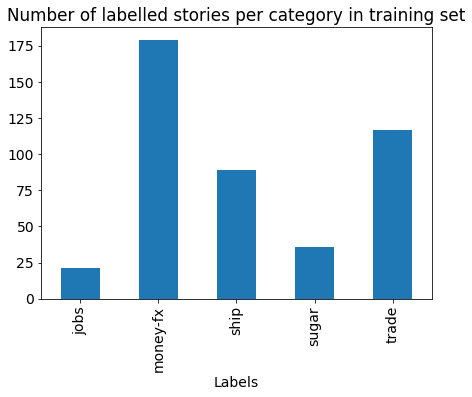

In [52]:
percentage_label_test.plot(kind='bar')

plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['font.size'] = 14
plt.xlabel("Labels")    
plt.title("Number of labelled stories per category in training set")

plt.show()

In [53]:
# Create list with tuples to evaluate the model we are creating against a model that picks labels based on probability
import math
percentage_test = []

labels = percentage_label_test.keys().tolist()

for i,label in enumerate(percentage_label_test):
    print(str(labels[i]) + ' '+ str(math.floor(label/542*100)) + " percent")
    
    percentage_test.append((labels[i], math.floor(label/542*100)))

jobs 3 percent
money-fx 33 percent
ship 16 percent
sugar 6 percent
trade 21 percent


In [54]:
percentage_test

[('jobs', 3), ('money-fx', 33), ('ship', 16), ('sugar', 6), ('trade', 21)]

### Create test data

In [55]:
# define X_test and y_test
X_test = data_test.text_string
y_test = data_test.label

In [56]:
# Create document-term matrix for test set
X_test_dtm = vect1.fit_transform(X_test)
X_test_dtm = vect1.transform(X_test)
print(('Features: ', X_test_dtm.shape[1]))

('Features: ', 3600)


## Use Naive Bayes to predict the labels


From the sklearn documentation: In spite of their apparently over-simplified assumptions, naive Bayes classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. They require a small amount of training data to estimate the necessary parameters. It is very popular for text classification.

Naive Bayes works under the assumption of independence: it assumes that the value of a particular feature is independent of the value of any other feature, given the class variabl. In other words the classifier assumes that there is no correlation between the different features. Despite this naive assumption, it has been shown that Naive Bayes Classifiers work quite well in real world situations.

In [57]:
X_train_dtm = vect1.fit_transform(X_train)
X_test_dtm = vect1.transform(X_test)


# Use Naive Bayes to predict the labels
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)


# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.929864253394


In [58]:
y_test.value_counts()

money-fx    179
trade       117
ship         89
sugar        36
jobs         21
Name: label, dtype: int64

The model predictst the right label for a story with a 92.9 per cent accuracy.

### Compare to different parameter settings

In [59]:
# Define a function that accepts a vectorizer and calculates the accuracy.
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print(('Features: ', X_train_dtm.shape[1]))
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_label = nb.predict(X_test_dtm)
    print(('Accuracy: ', metrics.accuracy_score(y_test, y_pred_label)))

In [60]:
# limit terms to 100
vect2 = CountVectorizer(min_df=2, stop_words='english', max_features=1000)
tokenize_test(vect2)

('Features: ', 1000)
('Accuracy: ', 0.9321266968325792)


Limiting the features to 1000 increases the accuracy slightly to 0.93 per cent accuracy

### Adding a stemmer to CountVecrotizer

Stemming will reduce words to their word stem, base or root form.

In [61]:
# build analyzer for stemming to add to CountVectorizer - using stemmer lowers accuracy score which is why I decided not
# to use a stemmer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))



In [62]:
stem_vectorizer = CountVectorizer(min_df=2, analyzer=stemmed_words, stop_words='english')
tokenize_test(stem_vectorizer)

('Features: ', 4393)
('Accuracy: ', 0.91855203619909498)


by adding a stemmer the accuracy decreases to 91.8 per cent

### Adding a stemmer and max. 1000 features

In [63]:
stem_vectorizer_maxf = CountVectorizer(min_df=2, analyzer=stemmed_words, max_features = 1000, stop_words='english')
tokenize_test(stem_vectorizer_maxf)

('Features: ', 1000)
('Accuracy: ', 0.920814479638009)


Accuracy with vec2 (vect2 = CountVectorizer(min_df=2, stop_words='english', max_features=1000)) is the highest. I will chose that model which has an accuracy of 93 per cent.

## Evaluate TF-IDF vectorizer

While a Count Vectorizer simply totals up the number of times a "word" appears in a document, the more complex TF-IDF Vectorizer analyzes the uniqueness of words between documents to find distinguishing characteristics.

In [64]:
Tfidfvect = TfidfVectorizer(stop_words='english', min_df=2, max_features=1000)


In [65]:
Tfidfvect = TfidfVectorizer(stop_words='english', min_df=2, max_features = 1000)
tokenize_test(Tfidfvect)

('Features: ', 1000)
('Accuracy: ', 0.89592760180995479)


Results with TF-IDF vectorizer are lower than with CountVectorizer. 

## Evaluate how good the model is doing

In [66]:
from  sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [67]:
# use best vector for prediction
X_train_dtm = vect2.fit_transform(X_train)
X_test_dtm = vect2.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

y_pred_label = nb.predict(X_test_dtm)
print(('Accuracy: ', metrics.accuracy_score(y_test, y_pred_label)))

('Accuracy: ', 0.9321266968325792)


Confusion matrix, without normalization
[[ 15   1   0   1   4]
 [  0 174   0   0   5]
 [  0   0  83   4   2]
 [  1   0   0  30   5]
 [  0   6   0   2 109]]
Normalized confusion matrix
[[ 0.71  0.05  0.    0.05  0.19]
 [ 0.    0.97  0.    0.    0.03]
 [ 0.    0.    0.93  0.04  0.02]
 [ 0.03  0.    0.    0.83  0.14]
 [ 0.    0.05  0.    0.02  0.93]]


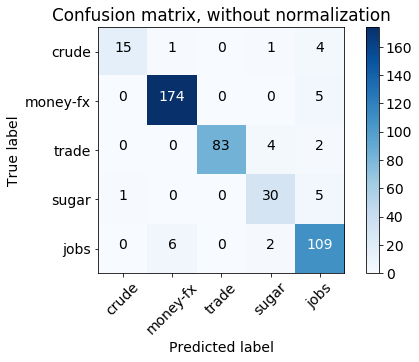

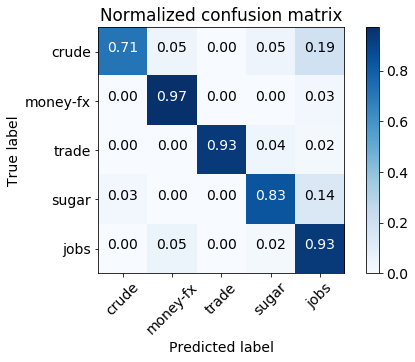

In [68]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= ['crude', 'money-fx', 'trade', 'sugar', 'jobs'], title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['crude', 'money-fx', 'trade', 'sugar', 'jobs'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

From the confusion matrix we can see that there were 9 False Negatives and 22 False Positives out of 442 stories. True positive rate is thus 0.94, False Positives rate 0.04 percent, True negative rate 2 per cent.

--- finish presentation

### For multiclass classification it is necessary to convert to binary

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred_class)
prec = precision_score(y_test, y_pred_class, average='weighted')
rec = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')

In [79]:
print("Accuracy is " + str(acc))
print("Precision is " + str(prec))
print("Recall is " + str(rec))
print("F1 score is " + str(f1))

Accuracy is 0.929864253394
Precision is 0.932077007365
Recall is 0.929864253394
F1 score is 0.929731774906


The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. Here it is calculated by passing in the acerage parameter to 'weighted' to work on multi labels. This calculates metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

## Quick test on accuracy with Decision Tree

In [71]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [72]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train_dtm, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [73]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_class))


0.929864253394


## Limitations and Outlook

This project predicts  labels of news stories with high accuracy. However, the topics are handpicked and distinct in the areas they cover. Also, stories are only labelled to one topic (single lable model). If more labels would be present, prediction to a single label will be more difficult, as the language for the topics might be less dinstinct. For exmpample, a story with the label 'rice' might be very similar to a story tagged to 'corn'. 

Moreover, a topic that is related to sugar might also be related to the topic trade. Since this model is only labelling the text to one topic, the potential user might miss out on stories that she/he considers important. The model could be improved by adding more labels and doing multi label classification. 

Accuracy results are quite high with this model. This raises the question of overfitting. Naive Bayes Classifiers are considered relatively immune to overfitting. Because of their simple assumption of independence of features, results suffer from high bias because complex relationships cannot be represented. At the same time, this simplicity prevents overfitting on the training data.

Finaly, this model can only be used in an environment where false positives are allowed. If 100 per cent accuracy is required, e.g. in a paid recommendation engine vs. a recommendation engine without charge, this model might be too inaccurate.